In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
targets = train['target']
train = train.drop(columns=['id', 'target'])
ids = test['id']
test = test.drop(columns=['id'])

['train.csv', 'sample_submission.csv', 'test.csv']


**Scale The Data**

In [48]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(test.values)
trans_data = transformer.transform(train.values)
trans_test = transformer.transform(test.values)

trans_data_df = pd.DataFrame(trans_data, columns=train.columns)
trans_test_df = pd.DataFrame(trans_test, columns=test.columns)

**Clustering Test Data**

In [49]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
center_point_0 = trans_data_df[targets == 0].mean()
#print(center_point_0)
center_point_1 = trans_data_df[targets == 1].mean()
start = np.array([center_point_0, center_point_1])
kmeans = KMeans(n_clusters=2, init=start).fit(test.values)
g_mix = GaussianMixture(n_components=2).fit(test.values)
#db_scan = DBSCAN(eps=75, min_samples=10).fit(test.values)


/opt/conda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


**Add Cluster Information To The Dataset**

In [50]:
predicts = kmeans.predict(train.values)
g_predicts= g_mix.predict(train.values)
count= 0
for i in range(len(predicts)):
    if targets[i] == predicts[i]:
        count+=1
print("K-Means Cluster Matches Target : ", str(count), " times out of 250")
data = pd.DataFrame(trans_data.copy(), columns=train.columns)
data['k_cluster'] = predicts
data['g_mix'] = g_predicts
t_data = pd.DataFrame(trans_test.copy(), columns=test.columns)
t_data['k_cluster'] = kmeans.predict(test.values)
t_data['g_mix'] = g_mix.predict(test.values)

K-Means Cluster Matches Target :  157  times out of 250


In [51]:
count=0
for i in range(len(g_predicts)):
    if targets[i] == g_predicts[i]:
        count+=1
print("For Gaussian-Mixture : ", count)

For Gaussian-Mixture :  118


**Check Variable Importances With RandomForests**

          0         1         2  ...         299  k_cluster  g_mix
0 -0.068010  1.611318  0.492216  ...   -0.793486          1      1
1  0.803548 -0.725242 -0.296516  ...    0.715026          0      0
2 -0.382184 -0.067014 -0.270571  ...   -0.901554          1      0
3  0.053964 -0.016381  0.277984  ...    0.170984          0      1
4  1.739420 -0.619509  0.366197  ...    0.182087          1      0

[5 rows x 302 columns]


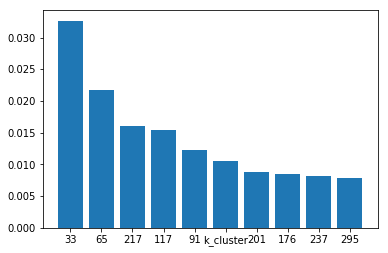

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import heapq
print(data.head())
rf = RandomForestClassifier(n_estimators=300, max_depth=5,random_state=0)
rf.fit(data.values, targets)
my_heap = []
for i in range(len(rf.feature_importances_)):
    heapq.heappush(my_heap, (-rf.feature_importances_[i], data.columns[i]))
heights = []
labels = []
for i in range(10):
    height, label = heapq.heappop(my_heap)
    heights.append(-height)
    labels.append(label)
plt.bar(range(10), height=heights, tick_label=labels)

plt.show()

We can see from this graph that k_cluster has a high importance

**Without Clustering**

In [53]:
param_grid = {"C": [.01, .1, 1, 10, 100, 1000],
                "penalty": ('l1','l2')}
top_data = data.drop(columns=['k_cluster', 'g_mix'])
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter = 1000)
gs = GridSearchCV(clf, param_grid, cv=5)
gs.fit(top_data.values, targets)
print(gs.best_score_)
print(gs.best_estimator_)
predictions = gs.predict_proba(t_data.drop(columns=['k_cluster', 'g_mix']).values)[:,1]
output = pd.DataFrame({'id' : ids, 'target' : predictions})
output.to_csv('scale_only_output.csv',index=None)

0.736
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


**With Clustering**

In [54]:
param_grid = {"C": [.01, .1, 1, 10, 100, 1000],
                "penalty": ('l1','l2')}
top_data = data
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter = 1000)
gs = GridSearchCV(clf, param_grid, cv=5)
gs.fit(top_data.values, targets)
print(gs.best_score_)
print(gs.best_estimator_)
predictions = gs.predict_proba(t_data.values)[:,1]
output = pd.DataFrame({'id' : ids, 'target' : predictions})
output.to_csv('scale_and_clustering_output.csv',index=None)

0.756
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


**With RFE+Clustering**

In [55]:
param_grid = {"C": [.01, .1, 1, 10, 100, 1000],
                "penalty": ('l1','l2')}
top_data = data[labels]
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter = 1000)
gs = GridSearchCV(clf, param_grid, cv=5)
gs.fit(top_data.values, targets)
print(gs.best_score_)
print(gs.best_estimator_)
predictions = gs.predict_proba(t_data[labels].values)[:,1]
output = pd.DataFrame({'id' : ids, 'target' : predictions})
output.to_csv('reduced_scale_and_clustering_output.csv',index=None)

0.788
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


I have tried submitting all of these, and Clustering without reducing the variables generalizes the best.
(Clustering for these scores was done before transforming the data)

The original 300 scaled score .816

Adding clustering increases to .837

The top 9 scaled variables and k_means scores .801